In [40]:
import numpy as np
np.random.seed(1000)
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import yfinance as yf
%matplotlib inline
import scipy.interpolate as sci

# Zwroty logarytmiczne

$$R_{\log}=\log\frac{S_{t+1}}{S_t}=\log S_{t+1}-\log S_{t},$$
gdzie $S_t$ jest ceną akcji w chwili $t$.

## Kontrolowany eksperyment (Monte Carlo) 

 **Zadanie 1)** Napiszemy funkcję która generuje ścieżki z GBM (Procesu Wienera).

In [2]:
def MC_paths(S0, r, sigma, T, M, I):
    ''' 
    Generujemy ścieżki z GBM.
    inputs
    ==========
    S0 : float -- początkowa cena akcji 
    r : float -- stopa wolna od ryzyka
    sigma : float -- zmienność
    T : float -- horyzont czasowy
    M : int -- liczba kroków
    I : int -- liczba ścieżek
    outputs
    =======
    ścieżki : tablica rozmaru (M + 1, I)

    '''
    dt = float(T) / M
    paths = np.zeros((M + 1, I), np.float64)
    paths[0] = S0
    for t in range(1, M + 1):
        rand = np.random.standard_normal(I)
        rand = (rand - rand.mean()) / rand.std()
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * rand)
    return paths

In [3]:
S0 = 100.
r = 0.05
sigma = 0.2
T = 1.0
M = 50
I = 250

In [4]:
paths = MC_paths(S0, r, sigma, T, M, I)

Text(0, 0.5, 'Wygenerowana cena akcji')

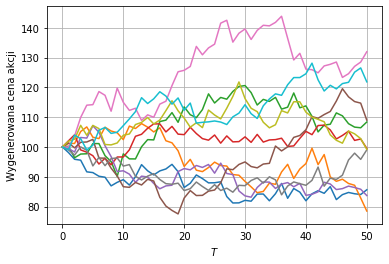

In [5]:
plt.plot(paths[:, :10])
plt.grid(True)
plt.xlabel('$T$')
plt.ylabel('Wygenerowana cena akcji')

In [6]:

stock_ret = [0.065, 0.0265, -0.0593, -0.001,0.0346]
mkt_ret = [0.055, -0.09, -0.041,0.045,0.022]
beta, alpha, r_value, p_value, std_err =stats.linregress(stock_ret,mkt_ret)
print(beta, alpha)

print( "R-squared=", r_value**2)
print("p-value =", p_value)


NameError: name 'stats' is not defined

In [7]:
log_returns = np.log(paths[1:] / paths[0:-1])

**Zadanie 2)** Napiszemy funkcję która pokazuje estymowane paramtry rozkładu 

In [8]:
def statystyki(array):
    ''' Prints selected statistics.
    inputs
    ==========
    tablica danych

    '''
    sta = scs.describe(array)
    print ("%14s %15s" % ('statystyka', 'wartość'))
    print (30 * "-")
    print ("%14s %15.5f" % ('size', sta[0]))
    print ("%14s %15.5f" % ('min', sta[1][0]))
    print ("%14s %15.5f" % ('max', sta[1][1]))
    print ("%14s %15.5f" % ('mean', sta[2]))
    print ("%14s %15.5f" % ('std', np.sqrt(sta[3])))
    print ("%14s %15.5f" % ('skośność', sta[4]))
    print ("%14s %15.5f" % ('kurtoza', sta[5]))

In [9]:
statystyki(log_returns.flatten())

    statystyka         wartość
------------------------------
          size     12500.00000
           min        -0.10209
           max         0.10441
          mean         0.00060
           std         0.02829
      skośność        -0.02138
       kurtoza        -0.07409


 **Zadanie 3)** Napiszemy test na normalność rozkładu

In [10]:
def test_normalnosc(tablica):
    ''' 
    inputs
    ==========
    tablica
    '''
    print ("skośność %26.3f" % scs.skew(tablica))
    print ("p-wartość skośności %15.3f" % scs.skewtest(tablica)[1])
    print ("kurtoza %27.3f" % scs.kurtosis(tablica))
    print ("p-wartość kurtozy %17.3f" % scs.kurtosistest(tablica)[1])
    print ("p-wartość testu normalności %7.3f" % scs.normaltest(tablica)[1])

In [11]:
test_normalnosc(log_returns.flatten())

skośność                     -0.021
p-wartość skośności           0.329
kurtoza                      -0.074
p-wartość kurtozy             0.085
p-wartość testu normalności   0.140


## Dane rynkowe 

In [112]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252
RISKY_ASSETS = ['FB', 'TSLA', 'TWTR', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
n_assets = len(RISKY_ASSETS)

In [113]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE,
end=END_DATE, adjusted=True)

[*********************100%***********************]  4 of 4 completed


In [114]:
returns_df = prices_df['Adj Close'].pct_change().dropna()
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [115]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /= np.sum(weights, axis=1)[:, np.newaxis]

In [118]:
portf_rtns = np.dot(weights, avg_returns)
portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T,np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)
portf_sharpe_ratio = portf_rtns / portf_vol

In [120]:
import pandas as pd
portf_results_df = pd.DataFrame({'returns': portf_rtns,
'volatility': portf_vol,
'sharpe_ratio':
portf_sharpe_ratio})

In [122]:
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []
portf_rtns_ef = np.linspace(portf_results_df.returns.min(),portf_results_df.returns.max(), N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)
for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))

portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

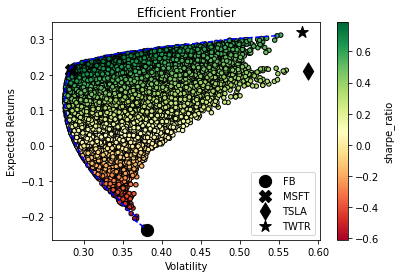

In [123]:
MARKS = ['o', 'X', 'd', '*']
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
y='returns', c='sharpe_ratio',
cmap='RdYlGn', edgecolors='black',
ax=ax)
ax.set(xlabel='Volatility',
ylabel='Expected Returns',
title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), y=avg_returns[asset_index],marker=MARKS[asset_index],s=150,color='black',
label=RISKY_ASSETS[asset_index])
ax.legend()
plt.s

In [124]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]
min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [127]:
print('Maximum Sharpe ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS,weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe ratio portfolio ----
Performance
returns: 23.42% volatility: 29.77% sharpe_ratio: 78.68% 
Weights
FB: 0.01% MSFT: 75.18% TSLA: 5.80% TWTR: 19.00% 

# Optymalizacja portfela


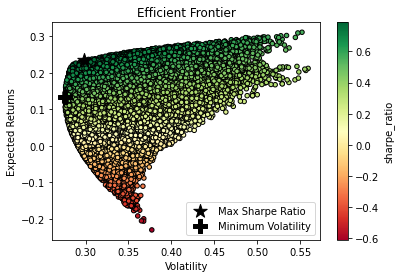

In [129]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
y='returns', c='sharpe_ratio',
cmap='RdYlGn', edgecolors='black',
ax=ax)
ax.scatter(x=max_sharpe_portf.volatility,
y=max_sharpe_portf.returns,
c='black', marker='*',
s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility,
y=min_vol_portf.returns,
c='black', marker='P',
s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns',
title='Efficient Frontier')
ax.legend()
plt.show()

In [78]:
def statystyki(wagi):
    ''' Returns portfolio statistics.
    Parameters
    ==========
    weights : array-like
    weights for different securities in portfolio
    Returns
    =======
    pret : float
    expected portfolio return
    pvol : float
    expected portfolio volatility
    pret / pvol : float
    Sharpe ratio for rf=0
    '''
    wagi = np.array(wagi)
    pret = np.sum(X.mean() * wagi) * 252
    pvol = np.sqrt(np.dot(wagi.T, np.dot(X.cov() * 252, wagi)))
    return np.array([pret, pvol, pret / pvol])

In [79]:
import scipy.optimize as sco

In [80]:
def minimalizacjaSR(wagi):
    return -statystyki(wagi)[2]

In [81]:
ograniczenia = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
stale = tuple((0, 1) for x in range(l_akcji))

In [82]:
l_akcji * [1. / l_akcji,]

[0.25, 0.25, 0.25, 0.25]

In [83]:
%%time
opts = sco.minimize(minimalizacjaSR, l_akcji * [1. / l_akcji,], method='SLSQP',
bounds=stale, constraints=ograniczenia)

CPU times: user 83.9 ms, sys: 4.01 ms, total: 87.9 ms
Wall time: 84.8 ms


In [84]:
opts

     fun: -22.403391678641253
     jac: array([-1.56164169e-04,  1.33479378e+01, -9.36508179e-04,  3.25441360e-04])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.11698326, 0.        , 0.2130088 , 0.67000794])

In [85]:
def minimalizacjaSD(wagi):
    return statystyki(wagi)[1] ** 2

In [86]:
optv = sco.minimize(minimalizacjaSD, l_akcji * [1. / l_akcji,], method='SLSQP',
bounds=stale, constraints=ograniczenia)

In [87]:
optv

     fun: 0.044525355912144474
     jac: array([0.08980264, 0.08910828, 0.08876139, 0.08903207])
 message: 'Optimization terminated successfully'
    nfev: 25
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.09279646, 0.18344772, 0.2469259 , 0.47682992])

In [88]:
optv['x'].round(3)

array([0.093, 0.183, 0.247, 0.477])

In [89]:
statystyki(optv['x'])

array([ 3.15853341,  0.21101032, 14.96862042])

# Brzeg efektywny

In [90]:
def min_func_vols(wagi):
    return statystyki(wagi)[1]

In [91]:
trl = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trl:
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    res = sco.minimize(min_func_vols, l_akcji * [1. / l_akcji,], method='SLSQP', bounds=stale, constraints=ograniczenia)
    tvols.append(res['fun'])
tvols = np.array(tvols)

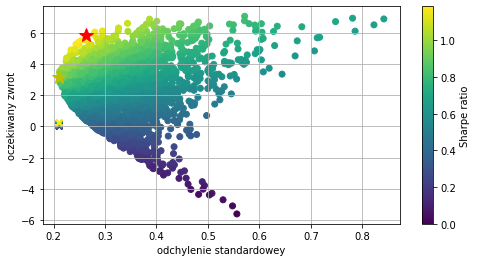

In [92]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,c=prets / pvols, marker='o')
# random portfolio composition
plt.scatter(tvols, trl, c=trl / tvols, marker='x')
# efficient frontier
plt.plot(statystyki(opts['x'])[1], statystyki(opts['x'])[0],'r*', markersize=15.0)
# portfolio with highest Sharpe ratio
plt.plot(statystyki(optv['x'])[1], statystyki(optv['x'])[0],'y*', markersize=15.0)
# minimum variance portfolio
plt.grid(True)
plt.xlabel('odchylenie standardowey')
plt.ylabel('oczekiwany zwrot')
plt.colorbar(label='Sharpe ratio')

In [93]:
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trl[ind:]

In [94]:
tck = sci.splrep(evols, erets)

In [95]:
def f(x):
    ''' Efficient frontier function (splines approximation). '''
    return sci.splev(x, tck, der=0)
def df(x):
    ''' First derivative of efficient frontier function. '''
    return sci.splev(x, tck, der=1)

In [96]:
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

In [99]:
opt = sco.fsolve(equations, [0.01, 0.2, 0.15])

In [100]:
opt

array([0.01, 0.2 , 0.15])

In [101]:
np.round(equations(opt), 6)

array([ 0., nan, nan])

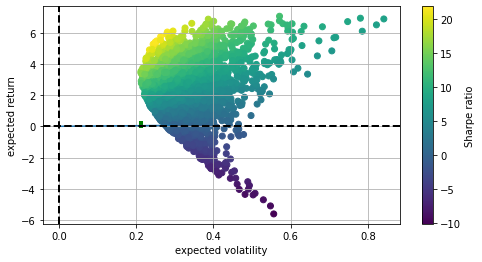

In [102]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
c=(prets - 0.01) / pvols, marker='o')
# random portfolio composition
plt.plot(evols, erets, 'g', lw=4.0)
# efficient frontier
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=1.5)
# capital market line
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')